In [67]:
import itertools
from ortools.sat.python import cp_model
import random
import time

def solve_fjs_with_parallel_machines(jobs_data,
                                     release_dates,
                                     due_dates,
                                     weights,
                                     setup_times,
                                     center_caps):
    model = cp_model.CpModel()

    # 1. 生成實體機台
    machines, center_of = [], {}
    for p, cap in center_caps.items():
        for k in range(cap):
            m = f"{p}_{k}"
            machines.append(m)
            center_of[m] = p

    # 2. 決策變數
    horizon = sum(d for ops in jobs_data.values() for d,_ in ops) \
              + max(due_dates.values())
    start, end, assign, tardiness = {}, {}, {}, {}

    for j, ops in jobs_data.items():
        for o, (dur, centers) in enumerate(ops):
            start[j, o] = model.NewIntVar(0, horizon, f"s_j{j}o{o}")
            end[j, o]   = model.NewIntVar(0, horizon, f"e_j{j}o{o}")
            # 只為允許的機台建 assign 變數
            valid = [m for m in machines if center_of[m] in centers]
            bools = []
            for m in valid:
                b = model.NewBoolVar(f"a_j{j}o{o}_m{m}")
                assign[j, o, m] = b
                bools.append(b)
                model.Add(end[j, o] == start[j, o] + dur).OnlyEnforceIf(b)
            model.AddExactlyOne(bools)

    # 3. 釋放時間與工序順序
    for j in jobs_data:
        model.Add(start[j, 0] >= release_dates[j])
        for o in range(len(jobs_data[j]) - 1):
            model.Add(start[j, o+1] >= end[j, o])

    # 4. 機台互斥 + 序依換線
    for m in machines:
        tasks = [(j, o) for j, ops in jobs_data.items()
                        for o, (_, centers) in enumerate(ops)
                        if center_of[m] in centers]
        for (j1, o1), (j2, o2) in itertools.combinations(tasks, 2):
            b = model.NewBoolVar(f"ord_{j1}o{o1}_{j2}o{o2}_on_{m}")
            p = center_of[m]
            s12 = setup_times.get(p, {}).get(((j1, o1), (j2, o2)), 0)
            s21 = setup_times.get(p, {}).get(((j2, o2), (j1, o1)), 0)

            model.Add(start[j2, o2] >= end[j1, o1] + s12)\
                 .OnlyEnforceIf([assign[j1, o1, m],
                                 assign[j2, o2, m], b])
            model.Add(start[j1, o1] >= end[j2, o2] + s21)\
                 .OnlyEnforceIf([assign[j1, o1, m],
                                 assign[j2, o2, m], b.Not()])

    # 5. 拖期與目標
    for j, ops in jobs_data.items():
        last = len(ops) - 1
        tardiness[j] = model.NewIntVar(0, horizon, f"T_j{j}")
        model.Add(tardiness[j] >= end[j, last] - due_dates[j])
    model.Minimize(sum(weights[j] * tardiness[j] for j in jobs_data))

    # 6. 求解
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 10
    status = solver.Solve(model)

    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        schedule = {}
        for j, ops in jobs_data.items():
            schedule[j] = []
            for o in range(len(ops)):
                st = solver.Value(start[j, o])
                en = solver.Value(end[j, o])
                # 只在 assign 有定義的機台中找被選中的那一台
                m_assigned = next(
                    m for m in machines
                    if (j, o, m) in assign
                    and solver.Value(assign[j, o, m]) == 1
                )
                schedule[j].append((o, m_assigned, st, en))
        return schedule, solver.ObjectiveValue()

    return None, None

def generate_random_instance(num_jobs=10, centers = ('C1','C2','C3'),
                             center_caps = {'C1':3,'C2':2,'C3':2},
                             num_ops=3):

    jobs_data, release_dates, due_dates, weights = {}, {}, {}, {}
    setup_times = {p:{} for p in centers}

    for j in range(num_jobs):
        ops = []
        for _ in range(num_ops):
            dur = random.randint(1, 10)
            avail = random.sample(centers, random.randint(1,2))
            ops.append((dur, avail))

        jobs_data[j] = ops
        release_dates[j] = random.randint(0, 5)
        due_dates[j]     = random.randint(10, 30)
        weights[j]       = random.randint(1, 5)

    # 隨機設定序依換線時間
    for p in centers:
        all_ops = [(j, o) for j, ops in jobs_data.items()
                          for o in range(len(ops))
                          if p in ops[o][1]]
        for (j1,o1),(j2,o2) in itertools.permutations(all_ops, 2):
            setup_times[p][((j1,o1),(j2,o2))] = random.randint(0, 3)

    return jobs_data, release_dates, due_dates, weights, setup_times, center_caps

if __name__ == "__main__":
    # 1. 生成隨機實例
    random.seed(42)
    jobs_data, release_dates, due_dates, weights, setup_times, center_caps = \
        generate_random_instance()

    # 2. 求解並計時
    start_time = time.time()
    schedule, obj = solve_fjs_with_parallel_machines(
        jobs_data, release_dates, due_dates, weights, setup_times, center_caps
    )
    elapsed = time.time() - start_time

    # 3. 輸出結果
    print(f"Jobs: {len(jobs_data)}, Centers: {center_caps}, Time: {elapsed:.2f}s")
    print(f"Objective Σ wj·Tj = {obj}\n")
    print("Job 排程 (job, op, machine, start, end):")

    for j in sorted(schedule):
        for o, m, st, en in schedule[j]:
            print(f"  Job{j}-Op{o} on {m}: [{st}, {en}]")


Jobs: 10, Centers: {'C1': 3, 'C2': 2, 'C3': 2}, Time: 10.08s
Objective Σ wj·Tj = 235.0

Job 排程 (job, op, machine, start, end):
  Job0-Op0 on C3_1: [14, 16]
  Job0-Op1 on C1_2: [23, 28]
  Job0-Op2 on C3_1: [31, 34]
  Job1-Op0 on C3_0: [1, 11]
  Job1-Op1 on C1_1: [21, 23]
  Job1-Op2 on C3_0: [24, 33]
  Job2-Op0 on C2_0: [20, 27]
  Job2-Op1 on C1_1: [27, 37]
  Job2-Op2 on C2_1: [37, 44]
  Job3-Op0 on C1_2: [0, 2]
  Job3-Op1 on C1_0: [2, 8]
  Job3-Op2 on C2_1: [20, 29]
  Job4-Op0 on C3_1: [0, 10]
  Job4-Op1 on C3_1: [12, 14]
  Job4-Op2 on C1_2: [14, 18]
  Job5-Op0 on C1_2: [5, 13]
  Job5-Op1 on C3_0: [13, 19]
  Job5-Op2 on C3_0: [19, 24]
  Job6-Op0 on C2_1: [0, 4]
  Job6-Op1 on C1_1: [6, 13]
  Job6-Op2 on C1_1: [13, 19]
  Job7-Op0 on C1_1: [1, 6]
  Job7-Op1 on C1_0: [8, 18]
  Job7-Op2 on C1_0: [19, 26]
  Job8-Op0 on C2_0: [0, 9]
  Job8-Op1 on C2_0: [9, 19]
  Job8-Op2 on C1_2: [20, 23]
  Job9-Op0 on C2_1: [5, 12]
  Job9-Op1 on C2_1: [12, 19]
  Job9-Op2 on C3_1: [19, 28]


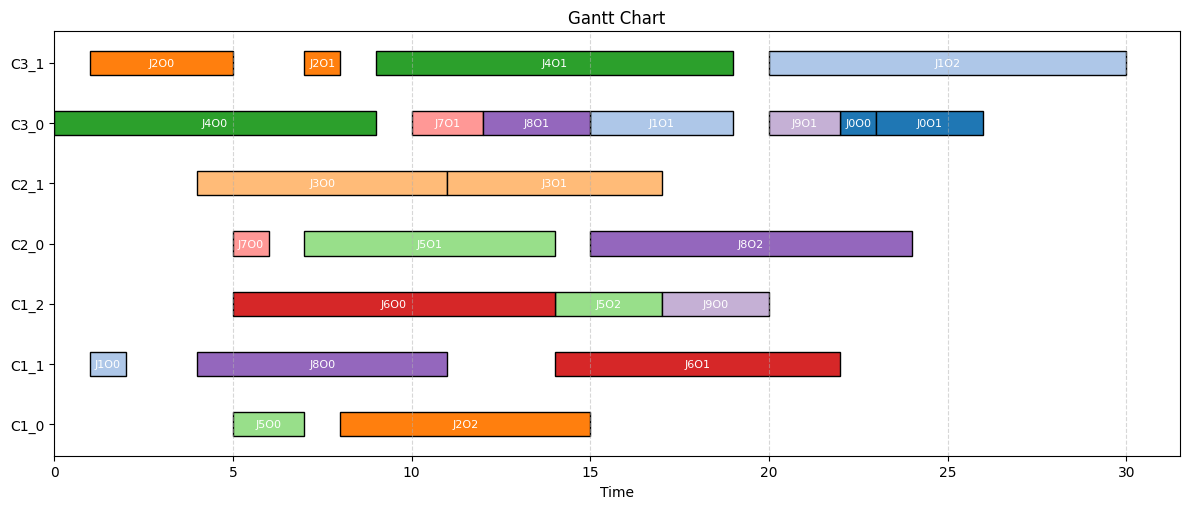

In [60]:
import matplotlib.pyplot as plt

def plot_gantt(schedule,
               title="Gantt Chart",
               filename=None):
    """
    schedule: dict
        { job_id: [ (op_idx, machine, start, end), ... ], ... }
    title: str
    filename: str or None, 若指定則儲存成檔案

    依機台排序繪製每個工序的水平長條，並於中間標上 JxOy。
    """
    # 1. 準備 y 軸：機台列表與對應座標
    machines = sorted({ m for ops in schedule.values() for _, m, _, _ in ops })
    y_pos = { m: i for i, m in enumerate(machines) }

    # 2. 顏色映射 (以 job_id 分組上色)
    cmap = plt.get_cmap("tab20")
    job_ids = sorted(schedule)
    color_map = { j: cmap(i % 20) for i, j in enumerate(job_ids) }

    # 3. 繪圖
    fig, ax = plt.subplots(figsize=(12, len(machines)*0.6+1))
    for j, ops in schedule.items():
        for op_idx, m, st, en in ops:
            ax.barh(y_pos[m],
                    en - st,
                    left=st,
                    height=0.4,
                    color=color_map[j],
                    edgecolor="black")
            ax.text(st + (en-st)/2,
                    y_pos[m],
                    f"J{j}O{op_idx}",
                    ha="center",
                    va="center",
                    color="white",
                    fontsize=8)

    # 4. 美化
    ax.set_yticks(list(y_pos.values()))
    ax.set_yticklabels(machines)
    ax.set_xlabel("Time")
    ax.set_title(title)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()

    # 5. 顯示或儲存
    if filename:
        plt.savefig(filename, dpi=200)
        print(f"甘特圖已儲存為 {filename}")
    plt.show()

plot_gantt(schedule)